# Are Baseball Batting Orders Optimal?

## Business Understanding
**Sports Analytics**

In all sports, analytics are being used to leverage every possible advantage. In modern baseball particularly, there is a wealth of data: players prepare and improve their personal skills, managers position defenders in revolutionary ways, front offices use data to sign free agents and plan spending.

**Batting Orders**

Before a game is played, the manager (along with the coaching staff and front office) assigns a starting pitcher and a batting order. Starting pitchers are typically used  on a 5-day rotating schedule while batting orders are very often consistent for the season with an age-old "formula":
- *Your fastest player who's best at getting on base should bat first.*
- *Your best "contact"-hitter should bat second in order to advance the lead-off hitter.*
- *Your overall best hitter should bat third (hopefully with two players already on base).*
- *Your best power-hitter should hit fourth ("cleanup") to "clean up" the bases with a home-run ideally.*

... and so on down the batting order.

**Can we improve on tradition?**

There is some intuition to this - especially that your best hitters should be hitting near the top of the batting order so they have more of a chance to get more plate-appearances in a game (the batting order rotates 1-9 back to 1 again). However, this concept of placing the hitters in this order is a hundred years old and should be challenged.

### Objectives
1. Use ML / Neural Networks to model baseball "events" (plate appearances). The models will use player data (Pitchers and Hitters) as well as additional game-data (temperature, field condition, etc) to **predict the outcome of a plate appearance.** 
 - *The predictions will importantly be **probabilistic** - showing the probability of each possible outcome (e.g.: Single, Out, Sacrifice, Strikeout). Therefore, the model should acknowledge some "human-nature" involved.
   - *Ex: If a player were to come to the plate in an identical situation 100 times, the results would vary even though the circumstances do not.*
2. Once we are able to figure probabilities of each outcome in a given situation, we will be **finding the optimal batting order** (measured by *expected runs-scored*).
 - *We will be simulating innings and measuring runs-scored while iterating through lineups.*

**After a simulation is run, we will be able to confidently say what batting order will produce the most runs on a given day against a given pitcher with given conditions.**

- **Name:** Claude Fried
- **Pace:** Part-time
- **Scheduled project review date/time:** 
- **Instructor name:** James Irving
- **Blog post URL:** 

### Imports

In [1]:
import os
import re
import pickle
import bz2
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.metrics import (classification_report, 
                             balanced_accuracy_score, 
                             log_loss)
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from scipy import sparse

import tensorflow as tf

import baseball_support as bsb
from league_player_classes import *

In [2]:
%matplotlib inline
plt.style.use(['ggplot', 'seaborn-talk'])
pd.set_option('display.max_columns', None)

# Set colors for plotting.
COLORS = {
    'blue': '#1f77b4',
    'green': '#2eb41f',
    'yellow': '#b4b21f',
    'red': '#b41f1f',
    'purple': '#b41f94',
    'grey': '#7d7d7d'
}

# Set random seed.
np.random.seed(2020)
tf.random.set_seed(2020)
tf.compat.v1.set_random_seed(2020)

# Check for device.
print(bsb.headerize(tf.test.gpu_device_name()))

********************************************************************************
*                                /device:GPU:0                                 *
********************************************************************************


# Obtain

## Data

The data is obtained and extracted from https://www.retrosheet.org/game.htm

> *The information used here was obtained free of charge from and is copyrighted by Retrosheet.*
>
> *Interested parties may contact Retrosheet at 20 Sunset Rd., Newark, DE 19711.*

Information on the event files can be found here: https://www.retrosheet.org/eventfile.htm

The players data can be found here: https://www.retrosheet.org/retroID.htm

### Downloading & extracting data from files.

The script can be used from this directory in the terminal:
```bash
$ python scrape_data_to_csv.py
```
...or in the cell below.

***

*It is not necessary to download any files manually.
If the directory `'./data'` does not exist, this file will download and unzip the necessary files and save them to the directory.*

***

> The script prompt:
> ```
> ########################################
> Press `enter` to download full dataset (beginning 1910).
> Otherwise, choose from:
>         [ s ] (`small`: starting 1980)
>         or
>         [1910, 1920, 1930, 1940, 1950, 1960, 1970, 1980, 1990, 2000]
> 
> ```

In [3]:
bsb.check_for_data()

********************************************************************************
*                             SUCCESS - Data Found                             *
********************************************************************************


In [4]:
# # Run this cell if the file './data' does not exist.
# # This requires internet access and may take a few minutes to run.
# %run scrape_data_to_csv.py

### Files

**GAMES**

- `[game_id, visiting_team_id, home_team_id, site_id, date, dblhdr_number, day_night, temp, wind, field_cond, precip, time_of_game, attendance]`

**EVENTS**

- `[game_id, inning_num, inning_half, hitter_id, pitcher_id, outcome]`

**TEAMS**

- `[team_id, year, league, location, name]`

In [5]:
games, events, teams = bsb.load_data()

games.shape, events.shape, teams.shape

((89381, 13), (7195607, 6), (1138, 5))

### Prepare `League`

In [6]:
MLB = League()
MLB


	**********LEAGUE**********
	Number of Hitters:  0
	Number of Pitchers: 0
	Total Players:      0

# Scrub

***Garbage in, garbage out.***

Since we scraped through a series of files that are formated pretty similarly, we can expect consistency with our data. We can also acknowledge that since we acquired the data ourselves and formatted it how we like, many of the issues with "*dirty data*" don't exist.

There are some things that we need to work on however with the data we have.

**The first thing to do is make sure the dtypes are correct and that missing values are addressed.**

## Games

Our `games` data can give us descriptive points on the games themselves - date, weather, day/night, sometimes field condition.

In [7]:
games.head()

,game_id,visiting_team_id,home_team_id,site_id,date,dblhdr_number,day_night,temp,wind,field_cond,precip,time_of_game,attendance
0,ATL198004170,CIN,ATL,ATL01,1980/04/17,0,night,0.0,-1.0,unknown,unknown,134,15742
1,ATL198004180,CIN,ATL,ATL01,1980/04/18,0,night,0.0,-1.0,unknown,unknown,108,5624
2,ATL198004190,CIN,ATL,ATL01,1980/04/19,0,night,0.0,-1.0,unknown,unknown,145,9684
3,ATL198004200,CIN,ATL,ATL01,1980/04/20,0,day,0.0,-1.0,unknown,unknown,153,8002
4,ATL198004220,SDN,ATL,ATL01,1980/04/22,0,night,0.0,-1.0,unknown,unknown,209,4710


In [8]:
games.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 89381 entries, 0 to 89380
Data columns (total 13 columns):
game_id             89381 non-null object
visiting_team_id    89381 non-null object
home_team_id        89381 non-null object
site_id             89381 non-null object
date                89381 non-null object
dblhdr_number       89381 non-null int64
day_night           89381 non-null object
temp                89380 non-null float64
wind                89380 non-null float64
field_cond          89380 non-null object
precip              89380 non-null object
time_of_game        89381 non-null int64
attendance          89381 non-null int64
dtypes: float64(2), int64(3), object(8)
memory usage: 9.5+ MB


In [9]:
# Fix dtypes.
games['date'] = pd.to_datetime(games['date'])

for c in ('temp', 'wind'):
    games[c] = games[c].map(lambda x: -1.0 if type(x)==str else x)
    games[c] = games[c].map(lambda x: -1 if x == 0 else x) # Correct "missing."
    games[c] = games[c].astype(float)

In [10]:
# Fill in missing values.
games.loc[games['site_id'].isna(), 
          'site_id'] = games[games['site_id'].isna()]['home_team_id']

games['temp'] = games['temp'].fillna(-1.0)
games['wind'] = games['wind'].fillna(-1.0)
games['field_cond'] = games['field_cond'].fillna('unknown')

# Fill na & `0.0` values with the median from the same time of day.
for t in ('day', 'night'):
    games.loc[((games['time_of_game'].isna()) | 
               (games['time_of_game'] == 0.0)), 
              'time_of_game'] = \
        games[games['day_night'] == t]['time_of_game'].median()

games['time_of_game'] = games['time_of_game'].astype(int)
games['precip'] = games['precip'].fillna('unknown')

games.loc[((games['attendance'].isna()) | 
           (games['attendance'] == 0.0)),
          'attendance'] = -1

games['attendance'] = games['attendance'].astype(int)

In [11]:
games.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 89381 entries, 0 to 89380
Data columns (total 13 columns):
game_id             89381 non-null object
visiting_team_id    89381 non-null object
home_team_id        89381 non-null object
site_id             89381 non-null object
date                89381 non-null datetime64[ns]
dblhdr_number       89381 non-null int64
day_night           89381 non-null object
temp                89381 non-null float64
wind                89381 non-null float64
field_cond          89381 non-null object
precip              89381 non-null object
time_of_game        89381 non-null int32
attendance          89381 non-null int32
dtypes: datetime64[ns](1), float64(2), int32(2), int64(1), object(7)
memory usage: 8.9+ MB


## Events

This is our main data. Each row represents an at-bat with the `hitter_id` and `pitcher_id` to decipher *who the outcome "belongs" to.*

In [12]:
events.head()

,game_id,inning_num,inning_half,hitter_id,pitcher_id,outcome
0,ATL198004170,1,0,colld001,niekp001,5/P
1,ATL198004170,1,0,grifk001,niekp001,K
2,ATL198004170,1,0,concd001,niekp001,43
3,ATL198004170,1,1,roysj001,pastf001,K/C
4,ATL198004170,1,1,pocob001,pastf001,8


In [13]:
events.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7195607 entries, 0 to 7195606
Data columns (total 6 columns):
game_id        object
inning_num     int64
inning_half    int64
hitter_id      object
pitcher_id     object
outcome        object
dtypes: int64(2), object(4)
memory usage: 384.3+ MB


In [14]:
events.isna().sum()

game_id        0
inning_num     0
inning_half    0
hitter_id      0
pitcher_id     0
outcome        0
dtype: int64

## Teams

This simple table shows us the teams that were competing in the league each year. Teams change locations, change names, change leagues, etc. This keeps track of that information.

In [15]:
teams.head()

,team_id,year,league,location,name
0,BAL,1980,A,Baltimore,Orioles
1,BOS,1980,A,Boston,Red Sox
2,CLE,1980,A,Cleveland,Indians
3,DET,1980,A,Detroit,Tigers
4,MIL,1980,A,Milwaukee,Brewers


In [16]:
teams.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1138 entries, 0 to 1137
Data columns (total 5 columns):
team_id     1138 non-null object
year        1138 non-null int64
league      1138 non-null object
location    1138 non-null object
name        1138 non-null object
dtypes: int64(1), object(4)
memory usage: 53.3+ KB


## Players

We have created a `PlayerFinder` class which will make the player table useful.

Our players table gives us player names and debut dates. We may use the debut column to see if we have complete records of a certain player who played at the start of our data.

The `PlayerFinder` can search for `player_ids` from names, as well as returning full names from `player_ids`.

In [17]:
playerfinder = bsb.PlayerFinder()
playerfinder


	**********PLAYER FINDER**********
	Number of player records loaded: 21284

In [18]:
# Example usage:
playerfinder.show_player('Griffey')
print('\n####################\n')
print(playerfinder.get_player_name('grifk001'))

             last first play_debut mgr_debut coach_debut ump_debut
id                                                                
grifk001  Griffey   Ken 1973-08-25       NaN  04/06/1993       NaN
grifk002  Griffey   Ken 1989-04-03       NaN         NaN       NaN

####################

Ken Griffey


## Engineer 

### `outcome`

Our main feature of the entire dataset is the `outcome` column from the events table. Each "event" is summarized with an outcome.

There are many types of outcomes - commonly hits & outs, but also *caught stealing* and *catcher's interference* are possible results of plays.

We must summarize the `outcome` column in order to have usable data to work with. The first part to this is to decipher the event "language" into the most meaningful parts.

In [19]:
# Example.
events['outcome'][:5]

0    5/P
1      K
2     43
3    K/C
4      8
Name: outcome, dtype: object

In [20]:
##################################################
# This processing takes a couple minutes to run. #
##################################################

# Load in pre-engineered events if exists.
if 'events_processed_outcome.pkl' in os.listdir('./data'):
    events = pd.read_pickle('./data/events_processed_outcome.pkl')

# Run `engineer_outcome()` to gather appropriate features from this column.
else:
    events = pd.concat(
        [events.drop('outcome', axis=1), 
         bsb.engineer_outcome(events['outcome'])], 
        axis=1
        )
    
    # Save results.
    events.to_pickle('./data/events_processed_outcome.pkl')

In [21]:
# Drop events which don't involve an outcome for the batter.
print('Number of No-Outcome Plays:', 
      f"{events['outcome'].isna().sum()}/{events.shape[0]}",
      '\nPercent Total:             ',
      f"{round(events['outcome'].isna().sum()/events.shape[0], 3)}%")
events.dropna(inplace=True)

events.head()

Number of No-Outcome Plays: 0/7062726 
Percent Total:              0.0%


,game_id,inning_num,inning_half,hitter_id,pitcher_id,outcome,total_bases,date,h_ab_coming_in,h_k%_coming_in,h_ops_coming_in,p_ip_coming_in,p_whip_coming_in,p_k_bb_coming_in
37778,CIN198004090,1,0,mille001,pastf001,K,0.0,1980-04-09,0,-1.0,-1.0,0.000000,-1.0,-1.0
37779,CIN198004090,1,0,roysj001,pastf001,O,0.0,1980-04-09,0,-1.0,-1.0,0.333333,0.0,-1.0
37780,CIN198004090,1,0,mattg001,pastf001,O,0.0,1980-04-09,0,-1.0,-1.0,0.666667,0.0,-1.0
37781,CIN198004090,1,1,colld001,niekp001,O,0.0,1980-04-09,0,-1.0,-1.0,0.000000,-1.0,-1.0
37782,CIN198004090,1,1,grifk001,niekp001,S,1.0,1980-04-09,0,-1.0,-1.0,0.333333,0.0,-1.0


In [22]:
events.shape

(7062726, 14)

## Add `date` to `events`

In [23]:
if 'date' not in events.columns: # If not already saved and loaded.
    events = pd.merge(events, games[['game_id', 'date']], on='game_id')
    
events.sort_values(['date', 'game_id', 'inning_num', 'inning_half'], 
                   inplace=True)
events.head()

,game_id,inning_num,inning_half,hitter_id,pitcher_id,outcome,total_bases,date,h_ab_coming_in,h_k%_coming_in,h_ops_coming_in,p_ip_coming_in,p_whip_coming_in,p_k_bb_coming_in
37778,CIN198004090,1,0,mille001,pastf001,K,0.0,1980-04-09,0,-1.0,-1.0,0.000000,-1.0,-1.0
37779,CIN198004090,1,0,roysj001,pastf001,O,0.0,1980-04-09,0,-1.0,-1.0,0.333333,0.0,-1.0
37780,CIN198004090,1,0,mattg001,pastf001,O,0.0,1980-04-09,0,-1.0,-1.0,0.666667,0.0,-1.0
37781,CIN198004090,1,1,colld001,niekp001,O,0.0,1980-04-09,0,-1.0,-1.0,0.000000,-1.0,-1.0
37782,CIN198004090,1,1,grifk001,niekp001,S,1.0,1980-04-09,0,-1.0,-1.0,0.333333,0.0,-1.0


### Player statistics

There are certain "live" stats for the players that can be used for modeling. 
- `{'stat'}_coming_in`, or "entering the at-bat" based on past performance.

They can also be used to hone in on the pinnacle of the player's career - the player's "prime" (which I'm not sure yet if I will use).

For the purposes of this model, I'll be satisfied to have everyone's stats begin at the earliest records we have available.

#### Stats

##### Offense (Hitters)
- **AB**: At-Bats
  - Simply the number of times the player records a statistical "at-bat". (Also referred to as *Plate Appearances*)
- **K%**: *Strikeout Rate*
  - Strikeouts per plate appearance.
- **OPS**: *On-Base Plus Slugging*
  - This stat combines two of the most valuable offensive stats we have in the game - on base percentage (how often a player reaches base) and slugging percentage (how many bases a player gets per hit).

> $\small OBP = \frac{H+BB+HBP}{AB+BB+SF+HBP}$
> 
> $\small SLG = \frac{TB}{AB}$
> 
> $\large OPS = OBP + SLG$

##### Defense (Pitchers)
- **IP**: Innings Pitched
  - Simply the number of innings pitched. Conventionally this is shown as `{innings}.{thirds_of_an_inning}` (e.g. $6.2 = 6 \frac{2}{3} innings$). We will be calculating and showing this as proper floats (e.g. $6.67 = 6 \frac{2}{3} innings$) so the calculations associated are correct.
- **WHIP**: *Walks plus Hits per Inning Pitched*
  - This stat tells simply how many base-runners a pitcher allows per inning pitched.
- **K/BB**: Strikeout to Walk Ratio
  - Exactly as it sounds - this stat shows how many strikeouts a pitcher achieves compared to how many walks they allow.

# Populating the League

At this point we can run `League.populate_league_with(data)` which does two things:
1. Create Players and career stats for every `player_id` in the dataset.
2. Update the data to include `{stat}_coming_in` for hitters and pitchers.

At the end of this process, our League will have all players and their rolling stats (one entry per "event").

Our data will also include `{stat}_heading_in`.

In [24]:
#########################################
# This processing takes a while to run. #
#########################################
f_name = './data/populated_league.pkl'

# Load in "pre-trained" League & updated `events`.
if 'populated_league.pkl' in os.listdir('./data'):
    print('Loading...')
    with bz2.open(f_name, 'rb') as infile:
        MLB = pickle.load(infile)
    events = pd.read_pickle('./data/events_processed_outcome.pkl')
    print('Complete.')
    
# Populate League and save `events`.
else:
    print('Processing...')
    MLB.populate_league_with(events)
    sfile = bz2.BZ2File(f_name, 'w')
    pickle.dump(MLB, sfile)
    events.to_pickle('./data/events_processed_outcome.pkl')
    print('Complete.')

Loading...
Complete.


In [25]:
MLB


	**********LEAGUE**********
	Number of Hitters:  7042
	Number of Pitchers: 4825
	Total Players:      11867

In [26]:
events.head()

,game_id,inning_num,inning_half,hitter_id,pitcher_id,outcome,total_bases,date,h_ab_coming_in,h_k%_coming_in,h_ops_coming_in,p_ip_coming_in,p_whip_coming_in,p_k_bb_coming_in
37778,CIN198004090,1,0,mille001,pastf001,K,0.0,1980-04-09,0,-1.0,-1.0,0.000000,-1.0,-1.0
37779,CIN198004090,1,0,roysj001,pastf001,O,0.0,1980-04-09,0,-1.0,-1.0,0.333333,0.0,-1.0
37780,CIN198004090,1,0,mattg001,pastf001,O,0.0,1980-04-09,0,-1.0,-1.0,0.666667,0.0,-1.0
37781,CIN198004090,1,1,colld001,niekp001,O,0.0,1980-04-09,0,-1.0,-1.0,0.000000,-1.0,-1.0
37782,CIN198004090,1,1,grifk001,niekp001,S,1.0,1980-04-09,0,-1.0,-1.0,0.333333,0.0,-1.0


# Explore

Here we can explore and visualize the data. We can do this at the 
1. event-level
2. player-level

In [27]:
# Include data on games (eg: weather, time, attendance, etc)
data = pd.merge(events.drop('date', axis=1), games, on='game_id')
data.columns

Index(['game_id', 'inning_num', 'inning_half', 'hitter_id', 'pitcher_id',
       'outcome', 'total_bases', 'h_ab_coming_in', 'h_k%_coming_in',
       'h_ops_coming_in', 'p_ip_coming_in', 'p_whip_coming_in',
       'p_k_bb_coming_in', 'visiting_team_id', 'home_team_id', 'site_id',
       'date', 'dblhdr_number', 'day_night', 'temp', 'wind', 'field_cond',
       'precip', 'time_of_game', 'attendance'],
      dtype='object')

## Events

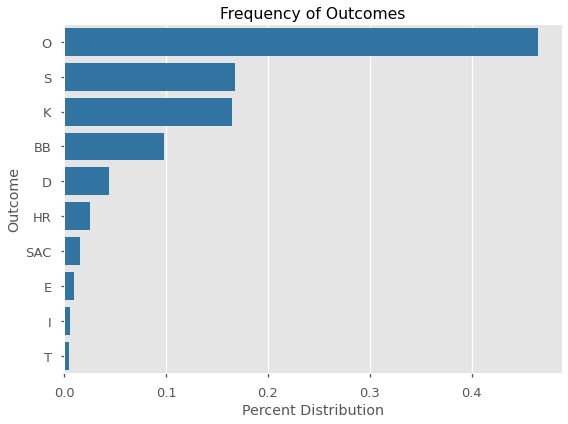

In [28]:
# Outcome frequency
fig, ax = plt.subplots(figsize=(8,6))
sns.barplot(x='outcome', y='index', orient='h', 
            data=data['outcome'].value_counts(normalize=True).reset_index(),
            color=COLORS['blue'], ax=ax)
ax.set(title='Frequency of Outcomes',
       ylabel='Outcome',
       xlabel='Percent Distribution')
fig.tight_layout()

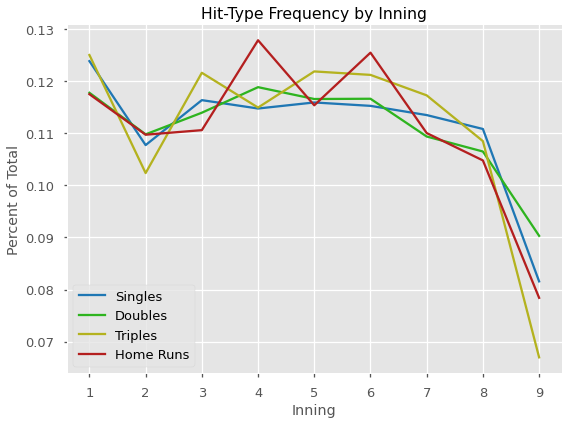

In [29]:
def get_outcome_type(events_df, outcome):
    """Queries events df for outcome-type frequency within first 9 innings."""
    return events_df[
        (events_df['outcome'] == outcome) & (events_df['inning_num'] <= 9)
    ]['inning_num'].value_counts(normalize=True).reset_index()


# Hit outcomes by inning.
fig, ax = plt.subplots(figsize=(8,6))
sns.lineplot(x='index', y='inning_num',
             data=get_outcome_type(data, 'S'), 
             label='Singles', color=COLORS['blue'], ax=ax)
sns.lineplot(x='index', y='inning_num',
             data=get_outcome_type(data, 'D'), 
             label='Doubles', color=COLORS['green'], ax=ax)
sns.lineplot(x='index', y='inning_num',
             data=get_outcome_type(data, 'T'), 
             label='Triples', color=COLORS['yellow'], ax=ax)
sns.lineplot(x='index', y='inning_num',
             data=get_outcome_type(data, 'HR'), 
             label='Home Runs', color=COLORS['red'], ax=ax)

ax.set(title='Hit-Type Frequency by Inning',
       ylabel='Percent of Total',
       xlabel='Inning')
fig.tight_layout()

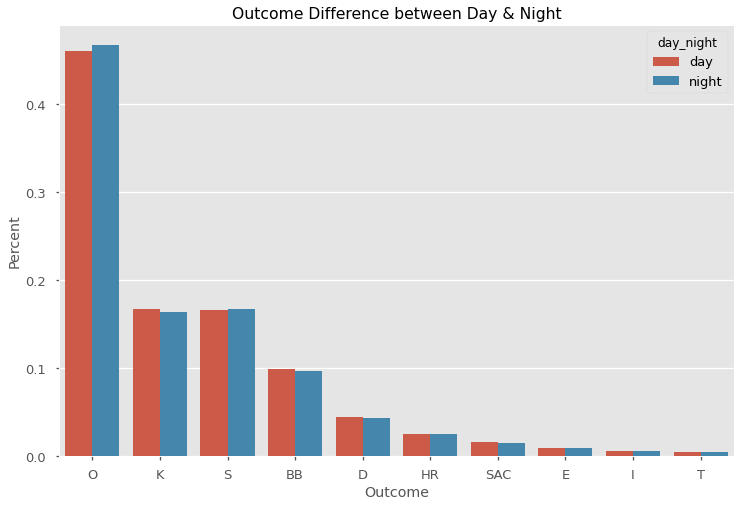

In [30]:
# Difference between day and night games.
fig, ax = plt.subplots()
sns.barplot(x='outcome', 
            y='percent',
            hue='day_night', 
            data=(data.groupby('day_night')['outcome']
                  .value_counts(normalize=True)
                  .rename('percent')
                  .reset_index()),
            ax=ax)
ax.set(title='Outcome Difference between Day & Night',
       xlabel='Outcome',
       ylabel='Percent')
fig.tight_layout()

In [31]:
# Player
# Plot career leaders for different tracked stats.

## Hitters

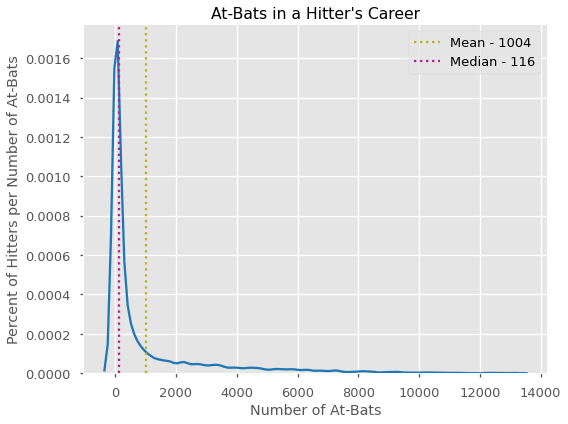

In [32]:
# Number of at-bats in a player's career.
total_ab = np.array([len(hitter.rolling_stats) 
                     for hitter in MLB.hitters.values()])
fig, ax = plt.subplots(figsize=(8,6))
sns.distplot(total_ab, hist=False, color=COLORS['blue'])
ax.axvline(total_ab.mean(), 
           label=f'Mean - {round(total_ab.mean())}', 
           ls=':', 
           color=COLORS['yellow'])
ax.axvline(np.median(total_ab), 
           label=f'Median - {round(np.median(total_ab))}', 
           ls=':', 
           color=COLORS['purple'])
ax.set(title="At-Bats in a Hitter's Career",
       xlabel='Number of At-Bats',
       ylabel='Percent of Hitters per Number of At-Bats')
ax.legend()
fig.tight_layout()

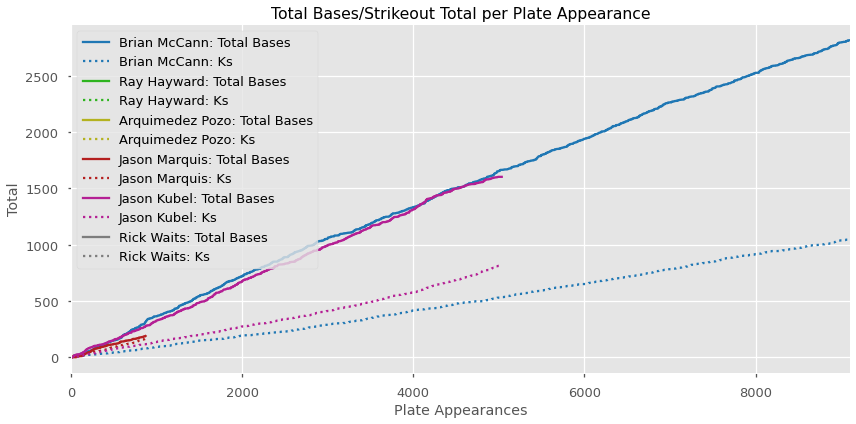

In [33]:
# Plotting random sample of Total Bases & Strikeouts.
random_hitter_sample = np.random.choice(
    [hitter for hitter in MLB.hitters.values()], 
    6, 
    replace=False
    )

fig, ax = plt.subplots(figsize=(12,6))
for hitter, color in zip(random_hitter_sample, COLORS.values()):
    hitter.get_rolling_stats_df()['tb'].plot(
        color=color, 
        label=playerfinder.get_player_name(hitter.player_id) + ': Total Bases',
        ax=ax
        )
    hitter.get_rolling_stats_df()['k'].plot(
        color=color,
        ls=':',
        label=playerfinder.get_player_name(hitter.player_id) + ': Ks',
        ax=ax
        )
ax.set(title='Total Bases/Strikeout Total per Plate Appearance',
       xlabel='Plate Appearances',
       ylabel='Total')
ax.legend()
fig.tight_layout()

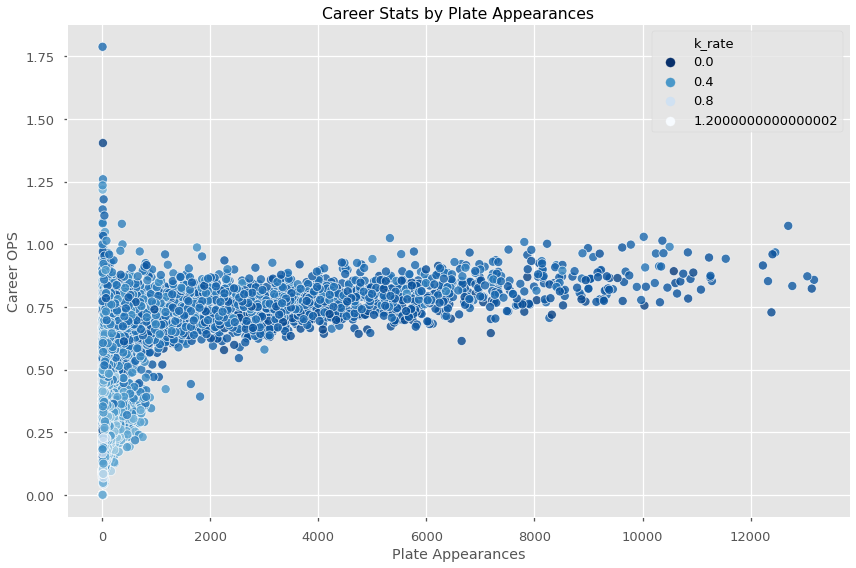

In [34]:
fig, ax = plt.subplots(figsize=(12,8))
# y=Career SLG
# x=Career Plate Appearances
ops_pa = pd.DataFrame([
    {'ops': hitter._Hitter__get_ops(),
     'k_rate': hitter._Hitter__get_strikeout_rate(),
     'pa': len(hitter.rolling_stats)}
    for hitter in MLB.hitters.values()
])

sns.scatterplot(x='pa', y='ops', hue='k_rate', 
                data=ops_pa[ops_pa['pa'] > 10], 
                palette='Blues_r',
                alpha=0.8,
                ax=ax)
ax.set(title='Career Stats by Plate Appearances',
       xlabel='Plate Appearances',
       ylabel='Career OPS')
fig.tight_layout()

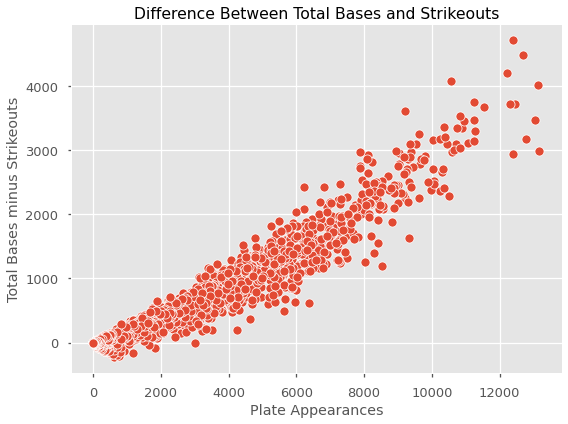

In [35]:
# Total bases minus strikeouts.
hits_rate_df = pd.DataFrame([
    {'bases_minus_k': hitter.career_stats['tb'] - hitter.career_stats['k'],
     'pa': len(hitter.rolling_stats)}
    for hitter in MLB.hitters.values()
])

fig, ax = plt.subplots(figsize=(8,6))
sns.scatterplot(x='pa', y='bases_minus_k', data=hits_rate_df, ax=ax)
ax.set(title='Difference Between Total Bases and Strikeouts',
       xlabel='Plate Appearances',
       ylabel='Total Bases minus Strikeouts')
fig.tight_layout()

## Pitchers

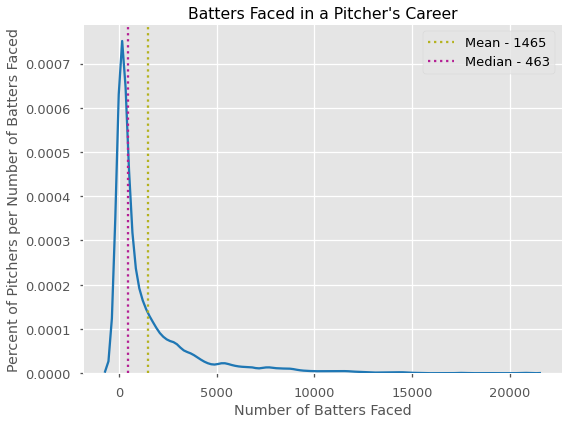

In [36]:
# Career batters faced.
total_batters_faced = np.array([len(pitcher.rolling_stats) 
                                for pitcher in MLB.pitchers.values()])
fig, ax = plt.subplots(figsize=(8,6))
sns.distplot(total_batters_faced, hist=False, color=COLORS['blue'])
ax.axvline(total_batters_faced.mean(), 
           label=f'Mean - {round(total_batters_faced.mean())}', 
           ls=':', 
           color=COLORS['yellow'])
ax.axvline(np.median(total_batters_faced), 
           label=f'Median - {round(np.median(total_batters_faced))}', 
           ls=':', 
           color=COLORS['purple'])
ax.set(title="Batters Faced in a Pitcher's Career",
       xlabel='Number of Batters Faced',
       ylabel='Percent of Pitchers per Number of Batters Faced')
ax.legend()
fig.tight_layout()

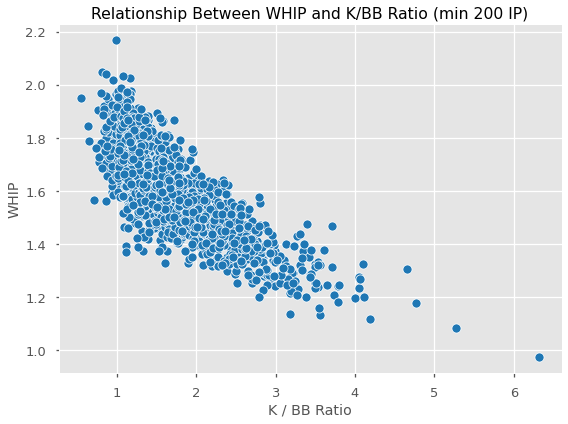

In [37]:
fig, ax = plt.subplots(figsize=(8,6))
sns.scatterplot(
    x='k_bb', 
    y='whip', 
    color=COLORS['blue'],
    ax=ax,
    data=pd.DataFrame([(pitcher._Pitcher__get_whip(), 
                        pitcher._Pitcher__get_k_bb_ratio())
                       for pitcher in MLB.pitchers.values()
                       if pitcher._Pitcher__get_ip() > 200], 
                      columns=['whip', 'k_bb'])
    )
ax.set(title='Relationship Between WHIP and K/BB Ratio (min 200 IP)',
       xlabel='K / BB Ratio',
       ylabel='WHIP')
fig.tight_layout()

## Player Impact on Outcome

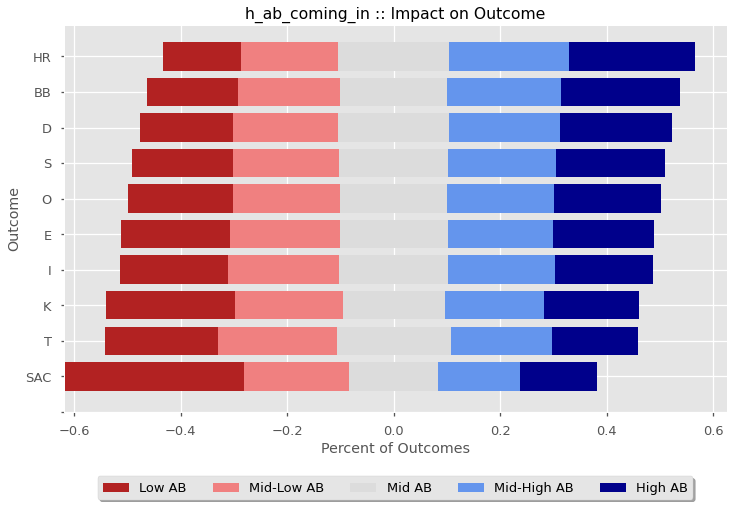

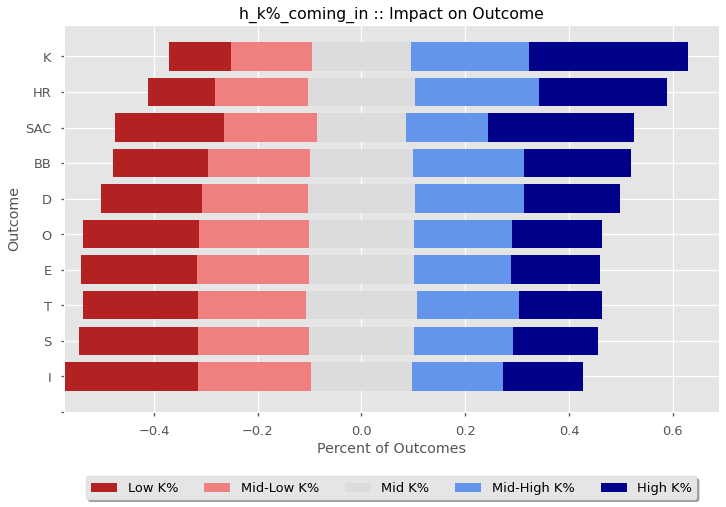

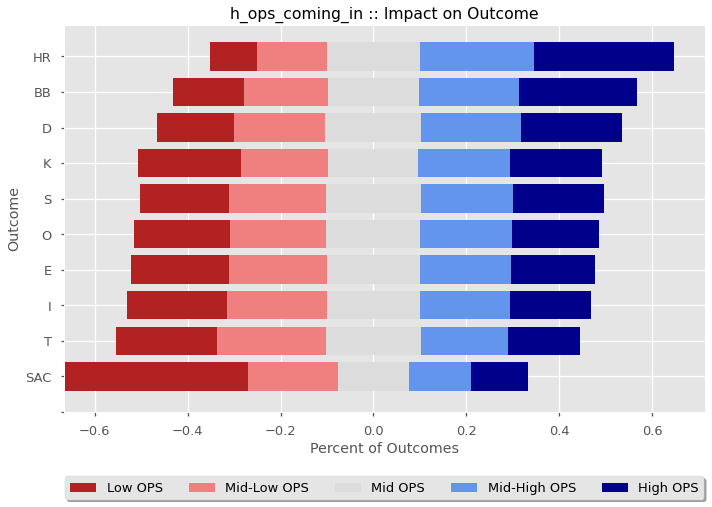

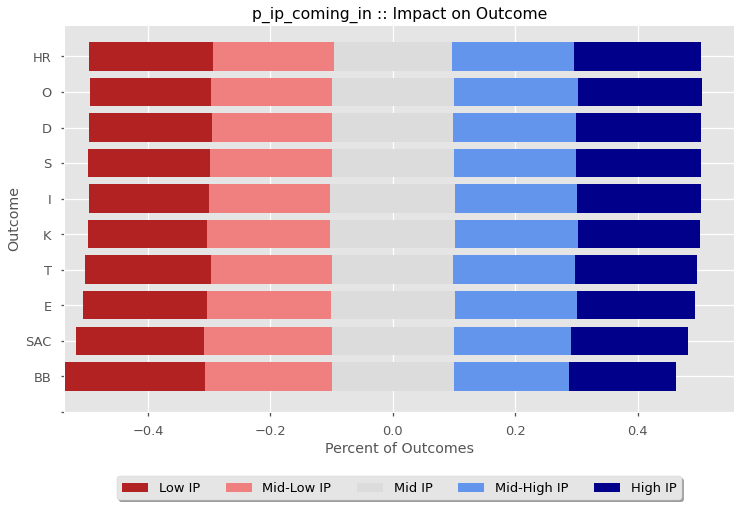

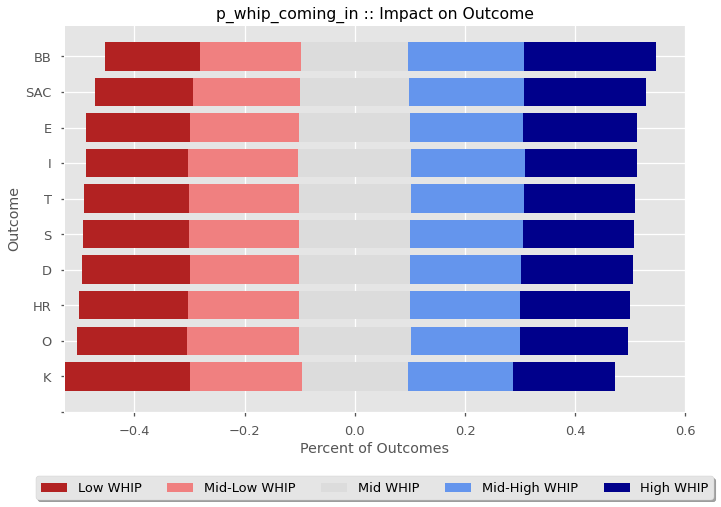

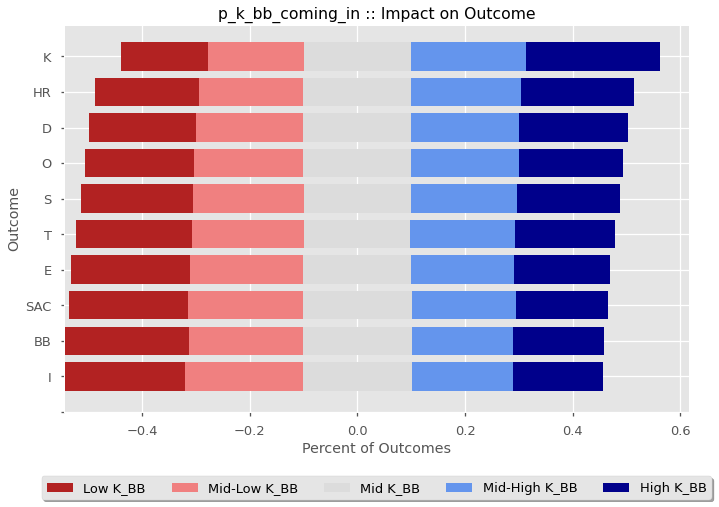

In [38]:
# Get (stat, abbreviation) from `{stat}_coming_in` columns.
coming_in_stats = [(col, col.split('_coming_in')[0][2:]) 
                   for col in events.columns if col.endswith('coming_in')]

for col, abbr in coming_in_stats:
    bsb.plot_stat_impact_on_outcome(df=events, 
                                    stat_column=col, 
                                    legend_label=abbr.upper())

# Prepare Data for Modeling

In [39]:
# train_test_split from games before 2017 and games since 2017.

## For data before 2017, a minimum of 4 years is added so 
## all players who debuted before the start year of the data
## have a number of at-bats and {stat}_heading_in data.
training_data = data[
    (data['date'] >= str(data['date'].min().year+4)) & 
    (data['date'] < '2017')
].copy()
testing_data = data[data['date'] >= '2017'].copy()

# Drop unneeded columns.
to_drop = ['game_id', 'date', 'visiting_team_id', 'home_team_id', 'site_id']
training_data.drop(columns=to_drop, inplace=True)
testing_data.drop(columns=to_drop, inplace=True)

# Set X and y
X_train = training_data.drop('outcome', axis=1)
y_train = training_data[['outcome']]
X_test = testing_data.drop('outcome', axis=1)
y_test = testing_data[['outcome']]

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((5897770, 19), (5897770, 1), (564198, 19), (564198, 1))

In [40]:
# Set up ColumnTransformer to process data.
cat_feats = ['hitter_id', 'pitcher_id', 'day_night', 'field_cond', 'precip']
cat_trans = OneHotEncoder(handle_unknown='ignore')

num_feats = [
    'inning_num',
    'inning_half',
    'total_bases',
    'h_ab_coming_in',
    'h_k%_coming_in',
    'h_ops_coming_in',
    'p_ip_coming_in',
    'p_whip_coming_in',
    'p_k_bb_coming_in',
    'dblhdr_number',
    'temp',
    'wind',
    'time_of_game',
    'attendance'
]
num_trans = StandardScaler()

X_preprocessor = ColumnTransformer([
    ('cat', cat_trans, cat_feats),
    ('num', num_trans, num_feats)
])
X_preprocessor

ColumnTransformer(n_jobs=None, remainder='drop', sparse_threshold=0.3,
                  transformer_weights=None,
                  transformers=[('cat',
                                 OneHotEncoder(categorical_features=None,
                                               categories=None, drop=None,
                                               dtype=<class 'numpy.float64'>,
                                               handle_unknown='ignore',
                                               n_values=None, sparse=True),
                                 ['hitter_id', 'pitcher_id', 'day_night',
                                  'field_cond', 'precip']),
                                ('num',
                                 StandardScaler(copy=True, with_mean=True,
                                                with_std=True),
                                 ['inning_num', 'inning_half', 'total_bases',
                                  'h_ab_coming_in', 'h_k%_coming_in',
         

In [41]:
X_train_processed = X_preprocessor.fit_transform(X_train)
X_test_processed = X_preprocessor.transform(X_test)

X_train_processed.shape, X_test_processed.shape

((5897770, 10067), (564198, 10067))

In [42]:
y_preprocessor = LabelEncoder()
y_preprocessor

LabelEncoder()

In [43]:
y_train_processed = y_preprocessor.fit_transform(y_train['outcome'])
y_test_processed = y_preprocessor.transform(y_test['outcome'])

y_train_processed.shape, y_test_processed.shape

((5897770,), (564198,))

## Save

In [63]:
# Save preprocessors.
modeling_preprocessors = [
    ('X_preprocessor', X_preprocessor),
    ('y_preprocessor', y_preprocessor)
]
for name, tool in modeling_preprocessors:
    print(f'Saving:\t{name}...')
    with open(f'./modeling/preprocessor/{name}.pkl', 'wb') as sfile:
        pickle.dump(tool, sfile)

# Save sparse matrices.
modeling_data = [
    ('X_train_processed', X_train_processed),
    ('X_test_processed', X_test_processed),
    ('y_train_processed', y_train_processed),
    ('y_test_processed', y_test_processed)
]
for name, tool in modeling_data:
    print(f'Saving:\t{name}...')
    if type(tool) == sparse.csr.csr_matrix:
        sparse.save_npz(f'./modeling/data/{name}.npz', tool)
    else:
        sparse.save_npz(f'./modeling/data/{name}.npz', sparse.csr_matrix(tool))
        
print('Complete!')

Saving:	X_preprocessor...
Saving:	y_preprocessor...
Saving:	X_train_processed...
Saving:	X_test_processed...
Saving:	y_train_processed...
Saving:	y_test_processed...
Complete!


# *Modeling in notebook: `modeling_outcomes`*